# Import

In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.6 MB/s eta 0:00:00a 0:00:01


In [2]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import warnings
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, classification_report

import transformers
import torch, torchaudio, torchtext
import torch.nn.functional as F
import torch.nn as nn

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score
from transformers import BertTokenizer, BertModel, AutoModel, AutoProcessor
from tqdm import tqdm

try:
    # try to import from local
    from CustomTransformer import CustomEncoder, PositionalEncoding, LayerNorm, PositionwiseFeedForward
except:
    # import from kaggle workspace
    from customtransformer import CustomEncoder, PositionalEncoding, LayerNorm, PositionwiseFeedForward

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.3f}'.format

2024-01-30 08:58:49.526107: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 08:58:49.526204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 08:58:49.663760: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Constants

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

"""
For the Argumentative Component Classification (ACC) task, we need to remove the 'O' label from the dataset.
"""
MODEL_NUM_LABELS = 3
REMOVE_OTHER = True
OTHER_LABEL = 'O'
    
if REMOVE_OTHER:
    MODEL_NUM_LABELS = 2

TEXT_MODEL_CARD = 'bert-base-uncased'
AUDIO_MODEL_CARD = 'facebook/wav2vec2-base-960h'

LABEL_2_ID = {
    'Claim': 0,
    'Premise': 1,
    'O': 2
}

ID_2_LABEL = {
    0: 'Claim',
    1: 'Premise',
    2: 'O'
}


EMBEDDING_DIM = 768
BATCH_SIZE = 12

Using device: cuda


# Load df

In [4]:
try:
    # Try to load from Kaggle workspace
    df_path = '/kaggle/input/multimodal-argument-mining/MM-USElecDeb60to16/MM-USElecDeb60to16.csv'
    audio_path = '/kaggle/input/multimodal-argument-mining/MM-USElecDeb60to16/audio_clips'
    load_path = '/kaggle/input/mm-dataset-subsampling/'
    save_path = '/kaggle/working/'
    df = pd.read_csv(df_path, index_col=0)
except FileNotFoundError:
    # Try to load from local
    df_path = 'multimodal-dataset/files/MM-USElecDeb60to16/MM-USElecDeb60to16.csv'
    audio_path = 'multimodal-dataset/files/MM-USElecDeb60to16/audio_clips'
    load_path = 'multimodal-dataset/files'
    save_path = 'multimodal-dataset/files'
    df = pd.read_csv(df_path, index_col=0)
    
# drop rows where audio length is 0
df = df[df['NewBegin'] != df['NewEnd']]
if REMOVE_OTHER:
    # drop rows where Component is 'Other'
    df = df[df['Component'] != OTHER_LABEL]

# train, val, test split
train_df_complete = df[df['Set'] == 'TRAIN']
val_df_complete = df[df['Set'] == 'VALIDATION']
test_df_complete = df[df['Set'] == 'TEST']

# subsample datasets for memory reasons
DATASET_RATIO = 1
train_df = train_df_complete.iloc[:int(DATASET_RATIO * len(train_df_complete))]
val_df = val_df_complete.iloc[:int(DATASET_RATIO * len(val_df_complete))]
test_df = test_df_complete.iloc[:int(DATASET_RATIO * len(test_df_complete))]

In [5]:
train_df.head()

,Text,Part,Document,Order,Sentence,Start,End,Annotator,Tag,Component,...,Speaker,SpeakerType,Set,Date,Year,Name,MainTag,NewBegin,NewEnd,idClip
3,"And, after 9/11, it became clear that we had t...",1,30_2004,3,3,2418,2744,NaN,"{""O"": 16, ""Claim"": 50}",Claim,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Claim,140.560,158.920,clip_3
4,And we also then finally had to stand up democ...,1,30_2004,4,4,2744,2974,NaN,"{""O"": 4, ""Claim"": 13, ""Premise"": 25}",Premise,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Mixed,158.920,172.920,clip_4
9,What we did in Iraq was exactly the right thin...,1,30_2004,9,9,3861,3916,NaN,"{""Claim"": 12, ""O"": 1}",Claim,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Claim,224.080,226.880,clip_9
10,"If I had it to recommend all over again, I wou...",1,30_2004,10,10,3916,4010,NaN,"{""Premise"": 19, ""O"": 1}",Premise,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Premise,226.880,231.560,clip_10
11,The world is far safer today because Saddam Hu...,1,30_2004,11,11,4010,4112,NaN,"{""Claim"": 6, ""O"": 2, ""Premise"": 13}",Premise,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Mixed,231.560,237.560,clip_11


In [6]:
print(f'Train size: {len(train_df)}')
print(f'Val size: {len(val_df)}')
print(f'Test size: {len(test_df)}')

Train size: 9455
Val size: 5201
Test size: 5908


## Distribution of classes over train df

In [7]:
num_claim = len(train_df[train_df['Component'] == 'Claim'])
print(f'Total Claim: {num_claim}: {num_claim*100/len(train_df):.2f}%')

num_premise = len(train_df[train_df['Component'] == 'Premise'])
print(f'Total Premise: {num_premise}: {num_premise*100/len(train_df):.2f}%')

if not REMOVE_OTHER:
    num_other = len(train_df[train_df['Component'] == 'O'])
    print(f'Total Other: {num_other}: {num_other*100/len(train_df):.2f}%')

Total Claim: 5029: 53.19%
Total Premise: 4426: 46.81%


Classes are not balanced, but not too bad either.

## Class Reweighting

In [8]:
if MODEL_NUM_LABELS == 2:
    claim_ratio = num_claim / (num_claim + num_premise)
    premise_ratio = num_premise / (num_claim + num_premise)
    weight = torch.tensor([1/(2*claim_ratio), 1/(2*premise_ratio)]).to(device)
else:
    claim_ratio = num_claim / (num_claim + num_premise + num_other)
    premise_ratio = num_premise / (num_claim + num_premise + num_other)
    other_ratio = num_other / (num_claim + num_premise + num_other)
    weight = torch.tensor([1/(3*claim_ratio), 1/(3*premise_ratio), 1/(3*other_ratio)]).to(device)

print(f'Weight for loss function: {weight}')

Weight for loss function: tensor([0.9400, 1.0681], device='cuda:0')


# Train and evaluation Loop

In [9]:
class BestModel:
    """
    Class to keep track of the best performing model on validation set during training
    """
    def __init__(self):
        self.best_validation_loss = float('Infinity')
        self.best_state_dict = None
    def __call__(self, model, loss):
        if loss < self.best_validation_loss:
            self.best_validation_loss = loss
            self.best_state_dict = copy.deepcopy(model.state_dict())

def evaluate(model, data_loader, loss_fn, debug=False):
    """
    Evaluate the model on the set passed
    Args:
        model: model to evaluate
        data_loader: DataLoader object
        loss_fn: loss function to use
        debug: whether to print debug statements
    """
    model.eval()
    total_loss = 0.0
    num_correct = 0 
    num_examples = 0
    tot_pred, tot_targ = torch.LongTensor().to(device), torch.LongTensor().to(device)
    for batch in data_loader:
        texts, audio_features, audio_attention, targets = batch
        audio_features = audio_features.to(device)
        audio_attention = audio_attention.to(device)
        targets = targets.to(device)
        output = model(texts,audio_features,audio_attention)
        if debug:
            print("OUTPUT",output)
            print("TARGETS", targets)
        loss = loss_fn(output, targets)
        total_loss += loss.detach()
        
        # if label O is still in the dataset we remove it from the outputs
        # since it's a binary task
        if not REMOVE_OTHER:
            not_other = targets != 2
            output = output[not_other]
            targets = targets[not_other]
        
        predicted_labels = torch.argmax(output[:, :2], dim=-1)
        tot_targ = torch.cat((tot_targ, targets))
        tot_pred = torch.cat((tot_pred, predicted_labels))            
        correct = torch.eq(predicted_labels, targets).view(-1)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    total_loss = total_loss.cpu().item()
    total_loss /= len(data_loader.dataset)
    accuracy = num_correct/num_examples
    f1 = multiclass_f1_score(tot_pred, tot_targ, num_classes=2, average="macro")
    return total_loss, accuracy, f1, tot_pred, tot_targ

            
def train(model, loss_fn, train_loader, val_loader, epochs=10, device="cuda", lr=1e-3, lr_decay_factor=0.1, lr_decay_patience=3, weight_decay=1e-5, verbose=True, debug=False):
    """
    Train the model on the train set and evaluate on the validation set with the given parameters
    Args:
        model: model to train
        loss_fn: loss function to use
        train_loader: DataLoader object for train set
        val_loader: DataLoader object for validation set
        epochs: number of epochs
        device: device to use
        lr: initial learning rate
        lr_decay_factor: factor to decay learning rate
        lr_decay_patience: patience for learning rate decay
        weight_decay: weight decay
        verbose: whether to print training results
        debug: whether to print debug statements
    """
    # set up optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_factor, patience=lr_decay_patience, verbose=True)
    best_model_tracker = BestModel()
    # history of train and validation losses, accuracy and f1
    history_train_losses = []
    history_train_accuracy = []
    history_train_f1 = []

    history_val_losses = []
    history_val_accuracy = []
    history_val_f1 = []

    for epoch in tqdm(range(epochs)):
        # training
        correct = 0
        training_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            texts, audio_features, audio_attention, targets = batch
            audio_features = audio_features.to(device)
            audio_attention = audio_attention.to(device)
            targets = targets.to(device)
            output = model(texts,audio_features,audio_attention)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            correct = torch.eq(torch.argmax(output, dim=-1), targets).view(-1)
            training_loss += loss.detach()
        training_loss = training_loss.cpu().item()

        training_loss /= len(train_loader.dataset)
        training_accuracy = correct.sum().item() / len(train_loader.dataset)
        training_f1 = multiclass_f1_score(torch.argmax(output, dim=-1), targets, num_classes=2, average="macro")

        valid_loss, valid_accuracy, valid_f1, _, _ = evaluate(model, val_loader, loss_fn, debug)

        history_train_losses.append(training_loss)
        history_train_accuracy.append(training_accuracy)
        history_train_f1.append(training_f1)

        history_val_losses.append(valid_loss)
        history_val_accuracy.append(valid_accuracy)
        history_val_f1.append(valid_f1)

        best_model_tracker(model, valid_loss)
        scheduler.step(valid_loss)
        if verbose:
            print(f'Epoch: {epoch}, Training Loss: {training_loss:.4f}, Validation Loss: {valid_loss:.4f}, accuracy = {valid_accuracy:.4f}, F1={valid_f1:.4f}')
    # restore best model weights
    model.load_state_dict(best_model_tracker.best_state_dict) 
    history = {
        'train_loss': history_train_losses,
        'train_accuracy': history_train_accuracy,
        'train_f1': history_train_f1,
        'val_loss': history_val_losses,
        'val_accuracy': history_val_accuracy,
        'val_f1': history_val_f1
    }
    return model, history

# Dataset Creation

In [10]:
# set up tokenizer and model
tokenizer = BertTokenizer.from_pretrained(TEXT_MODEL_CARD)
embedder = BertModel.from_pretrained(TEXT_MODEL_CARD).to(device)

# freeze bert layers
for params in embedder.parameters():
    params.requires_grad = False

# Downsample audio features to 1/5 of the original size to fit in memory
DOWNSAMPLE_FACTOR = 1/5

class MM_Dataset(torch.utils.data.Dataset):
    """
    Dataset class for multimodal dataset
    """
    def __init__(self, df, audio_dir, sample_rate):
        """
        Args:
            df: dataframe containing the dataset
            audio_dir: directory containing the audio clips
            sample_rate: sample rate to use for audio clips
        """
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate

        self.audio_processor = AutoProcessor.from_pretrained(AUDIO_MODEL_CARD)
        self.audio_model = AutoModel.from_pretrained(AUDIO_MODEL_CARD).to(device)

        self.dataset = []

        # Iterate over df
        for _, row in tqdm(df.iterrows()):
            path = os.path.join(self.audio_dir, f"{row['Document']}/{row['idClip']}.wav")
            if os.path.exists(path):
                # obtain audio WAV2VEC features
                audio, sampling_rate = torchaudio.load(path)
                # resample audio if necessary
                if sampling_rate != self.sample_rate:
                    audio = torchaudio.functional.resample(audio, sample_rate, self.sample_rate)
                    # mean pooling over channels
                    audio = torch.mean(audio, dim=0, keepdim=True)
                with torch.inference_mode():
                    # run audio through model
                    input_values = self.audio_processor(audio, sampling_rate=self.sample_rate).input_values[0]
                    input_values = torch.tensor(input_values).to(device)
                    audio_model_output = self.audio_model(input_values)
                    audio_features = audio_model_output.last_hidden_state[0].unsqueeze(0)
                    # downsample audio features
                    audio_features = torch.nn.functional.interpolate(audio_features.permute(0,2,1), scale_factor=DOWNSAMPLE_FACTOR, mode='linear')
                    audio_features = audio_features.permute(0,2,1)[0]
                    audio_features = audio_features.cpu()
                
                text = row['Text']

                self.dataset.append((text, audio_features, LABEL_2_ID[row['Component']]))
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return self.dataset[index]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [11]:
try:
    # try to restore datasets from memory
    train_dataset = torch.load(f'{load_path}/train_dataset.pkl')
    test_dataset = torch.load(f'{load_path}/test_dataset.pkl')
    val_dataset = torch.load(f'{load_path}/val_dataset.pkl')
    if REMOVE_OTHER:
        train_dataset = list(filter(lambda x: x[2] != 2, train_dataset))
        test_dataset = list(filter(lambda x: x[2] != 2, test_dataset))
        val_dataset = list(filter(lambda x: x[2] != 2, val_dataset))
    print('Restored datasets from memory')
except:
    # create new datasets
    print('Creating new datasets')
    train_dataset = MM_Dataset(train_df, audio_path, 16_000)
    test_dataset = MM_Dataset(test_df, audio_path, 16_000)
    val_dataset = MM_Dataset(val_df, audio_path, 16_000)

Restored datasets from memory


## Dataloader creation

In [12]:
def create_dataloader(dataset, batch_size):
    """
    Create a DataLoader object from the given dataset with the given batch size
    Args:
        dataset: dataset to use
        batch_size: batch size to use
    """
    def pack_fn(batch):
        """
        Function to pad the audio features and create the attention mask
        """
        texts = [x[0] for x in batch]
        audio_features = [x[1] for x in batch]
        labels = torch.tensor([x[2] for x in batch])
        
        # pad audio features
        audio_features = pad_sequence(audio_features, batch_first=True, padding_value=float('-inf'))
        audio_features_attention_mask = audio_features[:, :, 0] != float('-inf')
        audio_features[(audio_features == float('-inf'))] = 0
        return texts, audio_features, audio_features_attention_mask, labels

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pack_fn)
    return dataloader

In [13]:
train_dataloader = create_dataloader(train_dataset, BATCH_SIZE)
val_dataloader = create_dataloader(val_dataset, BATCH_SIZE)
test_dataloader = create_dataloader(test_dataset, BATCH_SIZE)

In [14]:
gc.collect()

18

In [15]:
def number_parameters(model):
    """
    Computes the number of trainable parameters in the model
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 0-A Text-Only

In [16]:
class TextModel(nn.Module):
    """
    Class for the text-only model
    """
    def __init__(self, tokenizer, embedder, head):
        """
        Args:
            tokenizer: tokenizer to use
            embedder: embedder to use
            head: head to use
        """
        super().__init__()
        self.tokenizer = tokenizer
        self.embedder = embedder
        self.head = head
    def forward(self, texts, audio_features, audio_attention):
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        tokenizer_output = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=False).to(device)
        embedder_output = self.embedder(**tokenizer_output, output_hidden_states=True)
        text_features = embedder_output['last_hidden_state']

        # pooling transformer output
        text_features_sum = (text_features * tokenizer_output.attention_mask.unsqueeze(-1)).sum(axis=1)
        text_features_pooled = text_features_sum / tokenizer_output.attention_mask.sum(axis=1).unsqueeze(-1)
        return self.head(text_features_pooled)

# 0-B Audio-Only

In [17]:
class AudioModel(nn.Module):        
    """
    Class for the audio-only model
    """
    def __init__(self, transformer, head, dropout_prob=0.1):
        """
        Args:
            transformer: transformer to use
            head: head to use
        """
        super().__init__()
        self.pos_encoder = PositionalEncoding(EMBEDDING_DIM, dual_modality=False)
        self.transformer = transformer
        self.head = head
        self.ln = LayerNorm(EMBEDDING_DIM)
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, texts, audio_features, audio_attention):
        global hard_debug
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        padding_mask = ~audio_attention.to(torch.bool)        
        full_attention_mask = torch.zeros((audio_features.shape[1],audio_features.shape[1]), dtype=torch.bool).to(device)
        
        audio_features = self.pos_encoder(audio_features)
        
        transformer_output = self.transformer(audio_features, mask=full_attention_mask, src_key_padding_mask=padding_mask)
        
        # Dropout and LayerNorm to help training phase
        transformer_output = self.dropout(transformer_output)
        transformer_output = self.ln(audio_features + transformer_output)

        transformer_output_sum = (transformer_output * audio_attention.unsqueeze(-1)).sum(axis=1)
        transformer_output_pooled = transformer_output_sum / audio_attention.sum(axis=1).unsqueeze(-1)

        return self.head(transformer_output_pooled)

# 1 - Crossmodal Self-Attention (CSA)

In [18]:
class CSA(nn.Module):
    """
    Class for the multimodal transformer model
    """
    def __init__(self, tokenizer, embedder, transformer, head, hidden_state_index=8):
        """
        Args:
            tokenizer: tokenizer to use
            embedder: embedder to use
            transformer: transformer to use
            head: head to use
        """
        super().__init__()
        self.pos_encoder = PositionalEncoding(EMBEDDING_DIM, dual_modality=False)
        self.tokenizer = tokenizer
        self.embedder = embedder
        self.transformer = transformer
        self.head = head
        self.hidden_state_index = hidden_state_index

    def forward(self, texts, audio_features, audio_attentions):
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        tokenizer_output = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=False).to(device)
        embedder_output = self.embedder(**tokenizer_output, output_hidden_states=True)
        if self.hidden_state_index == -1:
            text_features = embedder_output['last_hidden_state']
        else:
            assert self.hidden_state_index < len(embedder_output['hidden_states']), f'hidden_state_index must be between 0 and {len(embedder_output["hidden_states"])}'
            text_features = embedder_output['hidden_states'][self.hidden_state_index]
        text_attentions = tokenizer_output.attention_mask

        concatenated_attentions = torch.cat((text_attentions, audio_attentions.float()), dim=1)
        
        audio_features = self.pos_encoder(audio_features)
        
        concatenated_features = torch.cat((text_features, audio_features), dim=1)

        transformer_output = self.transformer(concatenated_features, text_attentions, audio_attentions)

        # pooling of transformer output        
        transformer_output_sum = (transformer_output * concatenated_attentions.unsqueeze(-1)).sum(axis=1)
        transformer_output_pooled = transformer_output_sum / concatenated_attentions.sum(axis=1).unsqueeze(-1)
        return self.head(transformer_output_pooled)

# 2 - Ensembling

In [19]:
 class Ensembling(nn.Module):
    """
    Class for the ensembling model
    """
    def __init__(self, text_model, audio_model, lower_bound=0.3, upper_bound=0.7):
        """
        Args:
            text_model: text model to use
            audio_model: audio model to use
            lower_bound: lower bound for the weight
            upper_bound: upper bound for the weight
        """
        super().__init__()
        self.text_model = text_model
        self.audio_model = audio_model
        # weight to balance the two models, 0 because (tanh(0)+1)/2 = 0.5 => equal weight to both models
        self.weight = torch.nn.Parameter(torch.tensor(0.0))
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        
    def forward(self, texts, audio_features, audio_attentions):
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        text_logits = self.text_model(texts, audio_features, audio_attentions)
        audio_logits = self.audio_model(texts, audio_features, audio_attentions)
        
        text_probabilities = torch.nn.functional.softmax(text_logits)
        audio_probabilities = torch.nn.functional.softmax(audio_logits)
        
        # coefficient to balance the two models based on weight learned
        # (tanh + 1) / 2 to have values in [0,1]
        coefficient = (torch.tanh(self.weight) + 1) / 2
        # next step is to have values in [lower_bound, upper_bound] to avoid too much imbalance
        coefficient = coefficient * (self.upper_bound - self.lower_bound) + self.lower_bound
        
        return coefficient*text_probabilities + (1-coefficient)*audio_probabilities

# 3 - Multimodal unaligned Text-Audio (MulT-TA)

In [20]:
class MulTA_CrossAttentionBlock(nn.Module):
    """
    Class for the cross modal attention block
    """
    def __init__(self, embedding_dim, d_ffn, num_heads=4, dropout_prob=0.1):
        """
        Args:
            embedding_dim: dimension of the embedding
            d_ffn: dimension of the feed forward layer
            num_heads: number of heads to use
            dropout_prob: dropout to use
        """
        super().__init__()
        self.embedding_dim = embedding_dim
        self.d_ffn = d_ffn
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob
        self.layer_norm = nn.LayerNorm(self.embedding_dim)
        self.mh_attention = nn.MultiheadAttention(embed_dim=self.embedding_dim, num_heads=self.num_heads, dropout=self.dropout_prob, batch_first=True)
        self.pointwise_ff = PositionwiseFeedForward(d_model=self.embedding_dim, hidden=self.d_ffn)
    
    def forward(self, elem_a, elem_b, attn_mask):
        """
        Forward pass of the model
        Args:
            elem_a: elements of the modality A
            elem_b: elements of the modality B
            attn_mask: attention mask to use
        """
        elem_a = self.layer_norm(elem_a)
        elem_b = self.layer_norm(elem_b)
        attn_mask = attn_mask.to(torch.float32)
        
        # cross modal attention with elem_a as query and elem_b as key and value
        mh_out, _ = self.mh_attention(elem_a, elem_b, elem_b, key_padding_mask=attn_mask, need_weights=False)
        # residual connection
        add_out = mh_out + elem_a
        
        add_out_norm = self.layer_norm(add_out)
        out_ffn = self.pointwise_ff(add_out_norm)
        out = out_ffn + add_out
        return out
    
class MulTA(nn.Module):
    """
    Class for the unaligned multimodal model
    """
    def __init__(self, embedding_dim, d_ffn, n_blocks, head, dropout_prob=0.1, hidden_state_index=8):
        """
        Args:
            embedding_dim: dimension of the embedding
            d_ffn: dimension of the feed forward layer
            n_blocks: number of blocks to use
            head: head to use
        """
        super().__init__()
        self.embedding_dim = embedding_dim
        self.d_ffn = d_ffn
        self.n_blocks = n_blocks
        self.head = head
        self.dropout_prob = dropout_prob
        self.text_crossmodal_blocks = nn.ModuleList([
            MulTA_CrossAttentionBlock(self.embedding_dim, self.d_ffn, dropout_prob=self.dropout_prob) for _ in range(self.n_blocks)
        ])
        self.audio_crossmodal_blocks = nn.ModuleList([
            MulTA_CrossAttentionBlock(self.embedding_dim, self.d_ffn,  dropout_prob=self.dropout_prob) for _ in range(self.n_blocks)
        ])
        self.pos_encoder = PositionalEncoding(embedding_dim, dual_modality=False)
        self.hidden_state_index = hidden_state_index
    
    def forward(self, texts, audio_features, audio_attentions):
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        tokenizer_output = tokenizer(texts, return_tensors='pt', padding=True, truncation=False).to(device)
        embedder_output = embedder(**tokenizer_output, output_hidden_states=True)
        if self.hidden_state_index == -1:
            text_features = embedder_output['last_hidden_state']
        else:
            assert self.hidden_state_index < len(embedder_output['hidden_states']), f'hidden_state_index must be between 0 and {len(embedder_output["hidden_states"])}'
            text_features = embedder_output['hidden_states'][self.hidden_state_index]
        text_features = self.pos_encoder(text_features)
        text_attentions = tokenizer_output.attention_mask
        
        audio_features = self.pos_encoder(audio_features)
        
        # cross modal attention blocks for text
        # using audio features as key and value and text features as query
        text_crossmodal_out = text_features
        for cm_block in self.text_crossmodal_blocks:
            text_crossmodal_out = cm_block(text_crossmodal_out, audio_features, audio_attentions)
        
        # cross modal attention blocks for audio
        # using text features as key and value and audio features as query
        audio_crossmodal_out = audio_features
        for cm_block in self.audio_crossmodal_blocks:
            audio_crossmodal_out = cm_block(audio_crossmodal_out, text_features, text_attentions)

        # pooling of transformer output
        text_crossmodal_out_mean = torch.mean(text_crossmodal_out, dim=1)
        audio_crossmodal_out_mean = torch.mean(audio_crossmodal_out, dim=1)
        
        # concatenate text and audio features
        text_audio = torch.cat((text_crossmodal_out_mean, audio_crossmodal_out_mean), dim=-1)
        
        return self.head(text_audio)

# Training of the models

In [21]:
def create_models(
        head_hidden_dimension=256, dropout_prob=0.1, hidden_state_index=8,   # shared parameters
        audioonly_nheads=8, audioonly_d_ffn=100, audioonly_n_layers=1, # audio only parameters
        csa_nheads=4, csa_d_ffn=2048, csa_n_layers=1, # multimodal parameters
        ensembling_nheads=4, ensembling_d_ffn=2048, ensembling_n_layers=1, # ensembling parameters
        multa_nblocks=4, multa_d_ffn=2048 # unaligned parameters
    ):
    """
    Creates all the models
    """
    ###################################################################################### -- TEXT MODEL --
    text_only_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    text_only = TextModel(tokenizer, embedder, text_only_head)


    ###################################################################################### -- AUDIO MODEL --   
    audio_only_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    audio_only_transformer_layer = nn.TransformerEncoderLayer(d_model=EMBEDDING_DIM, nhead=audioonly_nheads, dim_feedforward=audioonly_d_ffn, batch_first=True).to(device)
    audio_only_transformer_encoder = nn.TransformerEncoder(audio_only_transformer_layer, num_layers=audioonly_n_layers).to(device)
    audio_only = AudioModel(audio_only_transformer_encoder, audio_only_head).to(device)


    ###################################################################################### -- MULTIMODAL MODEL --
    multimodal_encoder = CustomEncoder(d_model=EMBEDDING_DIM, ffn_hidden=csa_d_ffn, n_head=csa_nheads, n_layers=csa_n_layers, drop_prob=dropout_prob)
    multimodal_transformer_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    multimodal_transformer = CSA(tokenizer, embedder, multimodal_encoder, multimodal_transformer_head, hidden_state_index=hidden_state_index).to(device)


    ###################################################################################### -- ENSEMBLING MODEL --
    ensembling_text_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    ensembling_audio_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    ensembling_transformer_layer = nn.TransformerEncoderLayer(d_model=EMBEDDING_DIM, nhead=ensembling_nheads, dim_feedforward=ensembling_d_ffn, batch_first=True).to(device)
    ensembling_transformer_encoder = nn.TransformerEncoder(ensembling_transformer_layer, num_layers=ensembling_n_layers).to(device)
    ensembling_text_model = TextModel(tokenizer, embedder, ensembling_text_head)
    ensembling_audio_model = AudioModel(ensembling_transformer_encoder, ensembling_audio_head)
    ensembling_fusion = Ensembling(ensembling_text_model, ensembling_audio_model).to(device)


    ###################################################################################### -- UNALIGNED MODEL --
    unaligned_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM*2, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    unaligned_mm_model = MulTA(embedding_dim=EMBEDDING_DIM, d_ffn=multa_d_ffn, n_blocks=multa_nblocks, head=unaligned_head, hidden_state_index=hidden_state_index, dropout_prob=dropout_prob).to(device)
    

    ###################################################################################### -- RETURN --
    model_names = ['Text-Only', 'Audio-Only', 'CSA', 'Ensembling', 'Mul-TA']
    models = [text_only, audio_only, multimodal_transformer, ensembling_fusion, unaligned_mm_model ]    
    return model_names, models

In [23]:
SEEDS = [1, 42, 69, 100, 420]

dict_model_names = ['Text-Only', 'Audio-Only', 'CSA', 'Ensembling', 'Mul-TA']

# initialize results
val_results = {n : [] for n in dict_model_names}
test_results = {n : [] for n in dict_model_names}

# initialize history
history_train_losses = {n : [] for n in dict_model_names}
history_train_accuracy = {n : [] for n in dict_model_names}
history_train_f1 = {n : [] for n in dict_model_names}
history_val_losses = {n : [] for n in dict_model_names}
history_val_accuracy = {n : [] for n in dict_model_names}
history_val_f1 = {n : [] for n in dict_model_names}

EPOCHS = 10
INITIAL_LR = 1e-4
WEIGHT_DECAY = 1e-3
LR_DECAY_FACTOR = 1e-1
LR_DECAY_PATIENCE = 3
VERBOSE_TRAIN = True
DEBUG_TRAIN = False

for seed in SEEDS:
    print(f'{f"TRAINING WITH SEED {seed}":=^100}')
    print()
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model_names, models = create_models()
    
    # TODO: copilot suggested this 2 lines, check if they are useful
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    
    # TO select a single model:
    # model_idx = 4
    # models, model_names = [models[model_idx]], [model_names[model_idx]]

    while models:
        model = models[0]
        model_name = model_names[0]
        torch.manual_seed(seed)
        np.random.seed(seed)
        print(f'{f"Training model {model_name}":_^100}')
        
        loss = nn.CrossEntropyLoss(weight=weight)
        
        if model_name == 'ensembling':
            loss = lambda outputs, targets: torch.nn.functional.nll_loss(torch.log(outputs), targets, weight=weight, reduction='mean')
            
        _, history = train(
            model,
            loss,
            train_dataloader,
            val_dataloader,
            epochs=EPOCHS,
            device=device,
            lr=INITIAL_LR,
            lr_decay_factor=LR_DECAY_FACTOR,
            lr_decay_patience=LR_DECAY_PATIENCE,
            weight_decay=WEIGHT_DECAY,
            verbose=VERBOSE_TRAIN,
            debug = DEBUG_TRAIN
        )
        
        history_train_losses[model_name].append(history['train_loss'])
        history_train_accuracy[model_name].append(history['train_accuracy'])
        history_train_f1[model_name].append(history['train_f1'])
        history_val_losses[model_name].append(history['val_loss'])
        history_val_accuracy[model_name].append(history['val_accuracy'])
        history_val_f1[model_name].append(history['val_f1'])

        _, val_acc, val_f1, val_pred, val_targ = evaluate(model, val_dataloader, loss)
        _, test_acc, test_f1, test_pred, test_targ = evaluate(model, test_dataloader, loss)
        if VERBOSE_TRAIN:
            print(f'[VAL] Model: {model_name} - acc: {val_acc:.4f} - f1: {val_f1:.4f}')
            print(f'[TEST] Model: {model_name} - acc: {test_acc:.4f} - f1: {test_f1:.4f}')
            print()
        val_results[model_name].append({'acc': val_acc,'f1': val_f1,'pred': val_pred,'targ': val_targ})
        test_results[model_name].append({'acc': test_acc,'f1': test_f1,'pred': test_pred,'targ': test_targ})
        
        del model
        del models[0]
        del model_names[0]
        gc.collect()


# save history
with open(f'{save_path}/history_train_losses.pkl', 'wb') as f:
    pickle.dump(history_train_losses, f)
with open(f'{save_path}/history_train_accuracy.pkl', 'wb') as f:
    pickle.dump(history_train_accuracy, f)
with open(f'{save_path}/history_train_f1.pkl', 'wb') as f:
    pickle.dump(history_train_f1, f)
    
with open(f'{save_path}/history_val_losses.pkl', 'wb') as f:
    pickle.dump(history_val_losses, f)
with open(f'{save_path}/history_val_accuracy.pkl', 'wb') as f:
    pickle.dump(history_val_accuracy, f)
with open(f'{save_path}/history_val_f1.pkl', 'wb') as f:
    pickle.dump(history_val_f1, f)

# save results
with open(f'{save_path}/val_results.pkl', 'wb') as f:
    pickle.dump(val_results, f)
with open(f'{save_path}/test_results.pkl', 'wb') as f:
    pickle.dump(test_results, f)

========================================TRAINING WITH SEED 1========================================

______________________________________Training model text_only______________________________________


 10%|█         | 1/10 [00:59<08:51, 59.02s/it]

Epoch: 0, Training Loss: 0.0495, Validation Loss: 0.0516, accuracy = 0.6849, F1=0.6754


 20%|██        | 2/10 [01:57<07:49, 58.75s/it]

Epoch: 1, Training Loss: 0.0474, Validation Loss: 0.0512, accuracy = 0.6768, F1=0.6723


 30%|███       | 3/10 [02:56<06:50, 58.63s/it]

Epoch: 2, Training Loss: 0.0470, Validation Loss: 0.0509, accuracy = 0.6837, F1=0.6803


 40%|████      | 4/10 [03:55<05:52, 58.77s/it]

Epoch: 3, Training Loss: 0.0464, Validation Loss: 0.0499, accuracy = 0.6856, F1=0.6827


 50%|█████     | 5/10 [04:53<04:53, 58.75s/it]

Epoch: 4, Training Loss: 0.0461, Validation Loss: 0.0515, accuracy = 0.6770, F1=0.6632


 60%|██████    | 6/10 [05:52<03:54, 58.65s/it]

Epoch: 5, Training Loss: 0.0457, Validation Loss: 0.0512, accuracy = 0.6804, F1=0.6796


 70%|███████   | 7/10 [06:51<02:56, 58.87s/it]

Epoch: 6, Training Loss: 0.0456, Validation Loss: 0.0500, accuracy = 0.6722, F1=0.6713


 80%|████████  | 8/10 [07:50<01:57, 58.99s/it]

Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 7, Training Loss: 0.0454, Validation Loss: 0.0503, accuracy = 0.6841, F1=0.6811


 90%|█████████ | 9/10 [08:49<00:59, 59.05s/it]

Epoch: 8, Training Loss: 0.0435, Validation Loss: 0.0499, accuracy = 0.6856, F1=0.6835


100%|██████████| 10/10 [09:48<00:00, 58.87s/it]

Epoch: 9, Training Loss: 0.0430, Validation Loss: 0.0501, accuracy = 0.6862, F1=0.6840


[VAL] Model: text_only - acc: 0.6856 - f1: 0.6827
[TEST] Model: text_only - acc: 0.6840 - f1: 0.6825

_____________________________________Training model audio_only______________________________________


 10%|█         | 1/10 [00:44<06:42, 44.68s/it]

Epoch: 0, Training Loss: 0.0581, Validation Loss: 0.0578, accuracy = 0.5036, F1=0.4994


 20%|██        | 2/10 [01:28<05:55, 44.44s/it]

Epoch: 1, Training Loss: 0.0577, Validation Loss: 0.0582, accuracy = 0.4628, F1=0.3432


 30%|███       | 3/10 [02:13<05:10, 44.39s/it]

Epoch: 2, Training Loss: 0.0577, Validation Loss: 0.0578, accuracy = 0.5297, F1=0.5123


 40%|████      | 4/10 [02:58<04:28, 44.71s/it]

Epoch: 3, Training Loss: 0.0576, Validation Loss: 0.0579, accuracy = 0.5214, F1=0.5170


 50%|█████     | 5/10 [03:43<03:43, 44.67s/it]

Epoch: 4, Training Loss: 0.0576, Validation Loss: 0.0579, accuracy = 0.5416, F1=0.4438


 60%|██████    | 6/10 [04:27<02:58, 44.73s/it]

Epoch: 5, Training Loss: 0.0576, Validation Loss: 0.0579, accuracy = 0.4961, F1=0.4831


 70%|███████   | 7/10 [05:12<02:14, 44.70s/it]

Epoch: 6, Training Loss: 0.0576, Validation Loss: 0.0577, accuracy = 0.5368, F1=0.5104


 80%|████████  | 8/10 [05:56<01:29, 44.61s/it]

Epoch: 7, Training Loss: 0.0576, Validation Loss: 0.0577, accuracy = 0.5332, F1=0.5120


 90%|█████████ | 9/10 [06:41<00:44, 44.60s/it]

Epoch: 8, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5257, F1=0.5163


100%|██████████| 10/10 [07:25<00:00, 44.59s/it]

Epoch: 9, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5264, F1=0.5163


[VAL] Model: audio_only - acc: 0.5368 - f1: 0.5104
[TEST] Model: audio_only - acc: 0.5501 - f1: 0.5306

_____________________________________Training model multimodal______________________________________


 10%|█         | 1/10 [01:34<14:11, 94.57s/it]

Epoch: 0, Training Loss: 0.0480, Validation Loss: 0.0515, accuracy = 0.7101, F1=0.7034


 20%|██        | 2/10 [03:09<12:37, 94.65s/it]

Epoch: 1, Training Loss: 0.0442, Validation Loss: 0.0479, accuracy = 0.7074, F1=0.7053


 30%|███       | 3/10 [04:43<11:01, 94.48s/it]

Epoch: 2, Training Loss: 0.0428, Validation Loss: 0.0489, accuracy = 0.7093, F1=0.7084


 40%|████      | 4/10 [06:19<09:30, 95.02s/it]

Epoch: 3, Training Loss: 0.0414, Validation Loss: 0.0495, accuracy = 0.7068, F1=0.7030


 50%|█████     | 5/10 [07:54<07:55, 95.03s/it]

Epoch: 4, Training Loss: 0.0403, Validation Loss: 0.0492, accuracy = 0.6951, F1=0.6895


 60%|██████    | 6/10 [09:29<06:20, 95.10s/it]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 5, Training Loss: 0.0391, Validation Loss: 0.0561, accuracy = 0.6989, F1=0.6965


 70%|███████   | 7/10 [11:04<04:45, 95.05s/it]

Epoch: 6, Training Loss: 0.0358, Validation Loss: 0.0533, accuracy = 0.7024, F1=0.7002


 80%|████████  | 8/10 [12:39<03:09, 94.89s/it]

Epoch: 7, Training Loss: 0.0350, Validation Loss: 0.0529, accuracy = 0.7026, F1=0.6996


 90%|█████████ | 9/10 [14:14<01:34, 94.92s/it]

Epoch: 8, Training Loss: 0.0341, Validation Loss: 0.0557, accuracy = 0.6974, F1=0.6951


100%|██████████| 10/10 [15:49<00:00, 94.92s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 9, Training Loss: 0.0338, Validation Loss: 0.0556, accuracy = 0.6953, F1=0.6920


[VAL] Model: multimodal - acc: 0.7074 - f1: 0.7053
[TEST] Model: multimodal - acc: 0.6977 - f1: 0.6970

_____________________________________Training model ensembling______________________________________


 10%|█         | 1/10 [01:36<14:24, 96.08s/it]

Epoch: 0, Training Loss: 0.0523, Validation Loss: 0.0513, accuracy = 0.6731, F1=0.6690


 20%|██        | 2/10 [03:12<12:49, 96.22s/it]

Epoch: 1, Training Loss: 0.0490, Validation Loss: 0.0509, accuracy = 0.6772, F1=0.6765


 30%|███       | 3/10 [04:48<11:11, 95.97s/it]

Epoch: 2, Training Loss: 0.0484, Validation Loss: 0.0506, accuracy = 0.6808, F1=0.6791


 40%|████      | 4/10 [06:24<09:38, 96.34s/it]

Epoch: 3, Training Loss: 0.0477, Validation Loss: 0.0504, accuracy = 0.6851, F1=0.6821


 50%|█████     | 5/10 [08:00<08:00, 96.20s/it]

Epoch: 4, Training Loss: 0.0473, Validation Loss: 0.0505, accuracy = 0.6835, F1=0.6771


 60%|██████    | 6/10 [09:37<06:25, 96.29s/it]

Epoch: 5, Training Loss: 0.0469, Validation Loss: 0.0504, accuracy = 0.6849, F1=0.6807


 70%|███████   | 7/10 [11:13<04:48, 96.19s/it]

Epoch: 6, Training Loss: 0.0470, Validation Loss: 0.0510, accuracy = 0.6708, F1=0.6697


 80%|████████  | 8/10 [12:48<03:11, 96.00s/it]

Epoch: 7, Training Loss: 0.0469, Validation Loss: 0.0502, accuracy = 0.6822, F1=0.6814


 90%|█████████ | 9/10 [14:25<01:36, 96.07s/it]

Epoch: 8, Training Loss: 0.0466, Validation Loss: 0.0503, accuracy = 0.6853, F1=0.6818


100%|██████████| 10/10 [16:01<00:00, 96.12s/it]

Epoch: 9, Training Loss: 0.0466, Validation Loss: 0.0503, accuracy = 0.6837, F1=0.6832


[VAL] Model: ensembling - acc: 0.6822 - f1: 0.6814
[TEST] Model: ensembling - acc: 0.6818 - f1: 0.6817

______________________________________Training model unaligned______________________________________


 10%|█         | 1/10 [03:21<30:10, 201.15s/it]

Epoch: 0, Training Loss: 0.0498, Validation Loss: 0.0529, accuracy = 0.6914, F1=0.6797


 20%|██        | 2/10 [06:42<26:52, 201.52s/it]

Epoch: 1, Training Loss: 0.0453, Validation Loss: 0.0479, accuracy = 0.7108, F1=0.7082


 30%|███       | 3/10 [10:03<23:26, 200.98s/it]

Epoch: 2, Training Loss: 0.0440, Validation Loss: 0.0499, accuracy = 0.7089, F1=0.7058


 40%|████      | 4/10 [13:26<20:10, 201.75s/it]

Epoch: 3, Training Loss: 0.0428, Validation Loss: 0.0478, accuracy = 0.7110, F1=0.7071


 50%|█████     | 5/10 [16:47<16:47, 201.51s/it]

Epoch: 4, Training Loss: 0.0422, Validation Loss: 0.0512, accuracy = 0.6862, F1=0.6674


 60%|██████    | 6/10 [20:09<13:26, 201.65s/it]

Epoch: 5, Training Loss: 0.0407, Validation Loss: 0.0518, accuracy = 0.7010, F1=0.7008


 70%|███████   | 7/10 [23:30<10:04, 201.59s/it]

Epoch: 6, Training Loss: 0.0394, Validation Loss: 0.0490, accuracy = 0.6958, F1=0.6957


 80%|████████  | 8/10 [26:51<06:42, 201.28s/it]

Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 7, Training Loss: 0.0387, Validation Loss: 0.0501, accuracy = 0.6985, F1=0.6985


 90%|█████████ | 9/10 [30:12<03:21, 201.30s/it]

Epoch: 8, Training Loss: 0.0348, Validation Loss: 0.0543, accuracy = 0.6997, F1=0.6975


100%|██████████| 10/10 [33:33<00:00, 201.40s/it]

Epoch: 9, Training Loss: 0.0337, Validation Loss: 0.0552, accuracy = 0.6974, F1=0.6946


[VAL] Model: unaligned - acc: 0.7139 - f1: 0.7099
[TEST] Model: unaligned - acc: 0.7035 - f1: 0.7009

=======================================TRAINING WITH SEED 42========================================

______________________________________Training model text_only______________________________________


 10%|█         | 1/10 [00:59<08:53, 59.23s/it]

Epoch: 0, Training Loss: 0.0502, Validation Loss: 0.0503, accuracy = 0.6854, F1=0.6840


 20%|██        | 2/10 [01:57<07:50, 58.87s/it]

Epoch: 1, Training Loss: 0.0476, Validation Loss: 0.0505, accuracy = 0.6839, F1=0.6772


 30%|███       | 3/10 [02:56<06:52, 58.94s/it]

Epoch: 2, Training Loss: 0.0466, Validation Loss: 0.0502, accuracy = 0.6826, F1=0.6821


 40%|████      | 4/10 [03:55<05:53, 58.93s/it]

Epoch: 3, Training Loss: 0.0460, Validation Loss: 0.0499, accuracy = 0.6853, F1=0.6833


 50%|█████     | 5/10 [04:55<04:55, 59.05s/it]

Epoch: 4, Training Loss: 0.0458, Validation Loss: 0.0509, accuracy = 0.6793, F1=0.6793


 60%|██████    | 6/10 [05:54<03:56, 59.10s/it]

Epoch: 5, Training Loss: 0.0452, Validation Loss: 0.0497, accuracy = 0.6895, F1=0.6859


 70%|███████   | 7/10 [06:53<02:57, 59.04s/it]

Epoch: 6, Training Loss: 0.0448, Validation Loss: 0.0531, accuracy = 0.6789, F1=0.6600


 80%|████████  | 8/10 [07:52<01:58, 59.04s/it]

Epoch: 7, Training Loss: 0.0448, Validation Loss: 0.0498, accuracy = 0.6889, F1=0.6879


 90%|█████████ | 9/10 [08:51<00:58, 58.99s/it]

Epoch: 8, Training Loss: 0.0443, Validation Loss: 0.0503, accuracy = 0.6893, F1=0.6887


100%|██████████| 10/10 [09:50<00:00, 59.02s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 9, Training Loss: 0.0439, Validation Loss: 0.0511, accuracy = 0.6847, F1=0.6726


[VAL] Model: text_only - acc: 0.6895 - f1: 0.6859
[TEST] Model: text_only - acc: 0.6818 - f1: 0.6802

_____________________________________Training model audio_only______________________________________


 10%|█         | 1/10 [00:45<06:45, 45.07s/it]

Epoch: 0, Training Loss: 0.0580, Validation Loss: 0.0581, accuracy = 0.4688, F1=0.3798


 20%|██        | 2/10 [01:29<05:57, 44.69s/it]

Epoch: 1, Training Loss: 0.0578, Validation Loss: 0.0577, accuracy = 0.5295, F1=0.5138


 30%|███       | 3/10 [02:14<05:13, 44.77s/it]

Epoch: 2, Training Loss: 0.0577, Validation Loss: 0.0578, accuracy = 0.5280, F1=0.5159


 40%|████      | 4/10 [02:59<04:29, 44.85s/it]

Epoch: 3, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5372, F1=0.5008


 50%|█████     | 5/10 [03:44<03:44, 44.88s/it]

Epoch: 4, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5224, F1=0.5146


 60%|██████    | 6/10 [04:29<02:59, 44.85s/it]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 5, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5051, F1=0.5031


 70%|███████   | 7/10 [05:14<02:14, 44.91s/it]

Epoch: 6, Training Loss: 0.0575, Validation Loss: 0.0577, accuracy = 0.5278, F1=0.5135


 80%|████████  | 8/10 [05:59<01:30, 45.06s/it]

Epoch: 7, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5266, F1=0.5135


 90%|█████████ | 9/10 [06:44<00:45, 45.14s/it]

Epoch: 8, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5255, F1=0.5166


100%|██████████| 10/10 [07:30<00:00, 45.01s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 9, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5268, F1=0.5136


[VAL] Model: audio_only - acc: 0.5295 - f1: 0.5138
[TEST] Model: audio_only - acc: 0.5487 - f1: 0.5373

_____________________________________Training model multimodal______________________________________


 10%|█         | 1/10 [01:34<14:11, 94.62s/it]

Epoch: 0, Training Loss: 0.0475, Validation Loss: 0.0488, accuracy = 0.7083, F1=0.7070


 20%|██        | 2/10 [03:08<12:31, 93.91s/it]

Epoch: 1, Training Loss: 0.0442, Validation Loss: 0.0499, accuracy = 0.7139, F1=0.7071


 30%|███       | 3/10 [04:42<10:58, 94.07s/it]

Epoch: 2, Training Loss: 0.0426, Validation Loss: 0.0479, accuracy = 0.7089, F1=0.7086


 40%|████      | 4/10 [06:16<09:25, 94.17s/it]

Epoch: 3, Training Loss: 0.0409, Validation Loss: 0.0486, accuracy = 0.7004, F1=0.6986


 50%|█████     | 5/10 [07:50<07:51, 94.23s/it]

Epoch: 4, Training Loss: 0.0395, Validation Loss: 0.0536, accuracy = 0.6899, F1=0.6899


 60%|██████    | 6/10 [09:24<06:16, 94.10s/it]

Epoch: 5, Training Loss: 0.0380, Validation Loss: 0.0516, accuracy = 0.6991, F1=0.6955


 70%|███████   | 7/10 [10:58<04:41, 93.98s/it]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 6, Training Loss: 0.0366, Validation Loss: 0.0569, accuracy = 0.6972, F1=0.6865


 80%|████████  | 8/10 [12:33<03:08, 94.18s/it]

Epoch: 7, Training Loss: 0.0331, Validation Loss: 0.0556, accuracy = 0.7006, F1=0.6989


 90%|█████████ | 9/10 [14:07<01:34, 94.21s/it]

Epoch: 8, Training Loss: 0.0313, Validation Loss: 0.0574, accuracy = 0.6974, F1=0.6950


100%|██████████| 10/10 [15:41<00:00, 94.17s/it]

Epoch: 9, Training Loss: 0.0311, Validation Loss: 0.0590, accuracy = 0.6960, F1=0.6950


[VAL] Model: multimodal - acc: 0.7089 - f1: 0.7086
[TEST] Model: multimodal - acc: 0.7016 - f1: 0.7016

_____________________________________Training model ensembling______________________________________


 10%|█         | 1/10 [01:35<14:19, 95.52s/it]

Epoch: 0, Training Loss: 0.0520, Validation Loss: 0.0513, accuracy = 0.6733, F1=0.6725


 20%|██        | 2/10 [03:10<12:39, 94.93s/it]

Epoch: 1, Training Loss: 0.0490, Validation Loss: 0.0508, accuracy = 0.6856, F1=0.6811


 30%|███       | 3/10 [04:45<11:05, 95.11s/it]

Epoch: 2, Training Loss: 0.0482, Validation Loss: 0.0505, accuracy = 0.6837, F1=0.6831


 40%|████      | 4/10 [06:20<09:30, 95.15s/it]

Epoch: 3, Training Loss: 0.0476, Validation Loss: 0.0505, accuracy = 0.6837, F1=0.6813


 50%|█████     | 5/10 [07:56<07:57, 95.44s/it]

Epoch: 4, Training Loss: 0.0476, Validation Loss: 0.0508, accuracy = 0.6774, F1=0.6772


 60%|██████    | 6/10 [09:32<06:22, 95.60s/it]

Epoch: 5, Training Loss: 0.0472, Validation Loss: 0.0504, accuracy = 0.6851, F1=0.6794


 70%|███████   | 7/10 [11:07<04:46, 95.59s/it]

Epoch: 6, Training Loss: 0.0468, Validation Loss: 0.0520, accuracy = 0.6747, F1=0.6544


 80%|████████  | 8/10 [12:43<03:11, 95.63s/it]

Epoch: 7, Training Loss: 0.0469, Validation Loss: 0.0501, accuracy = 0.6826, F1=0.6816


 90%|█████████ | 9/10 [14:19<01:35, 95.61s/it]

Epoch: 8, Training Loss: 0.0467, Validation Loss: 0.0505, accuracy = 0.6810, F1=0.6808


100%|██████████| 10/10 [15:54<00:00, 95.49s/it]

Epoch: 9, Training Loss: 0.0464, Validation Loss: 0.0505, accuracy = 0.6856, F1=0.6789


[VAL] Model: ensembling - acc: 0.6826 - f1: 0.6816
[TEST] Model: ensembling - acc: 0.6830 - f1: 0.6828

______________________________________Training model unaligned______________________________________


 10%|█         | 1/10 [03:21<30:10, 201.19s/it]

Epoch: 0, Training Loss: 0.0497, Validation Loss: 0.0493, accuracy = 0.6883, F1=0.6879


 20%|██        | 2/10 [06:40<26:38, 199.86s/it]

Epoch: 1, Training Loss: 0.0457, Validation Loss: 0.0549, accuracy = 0.6768, F1=0.6512


 30%|███       | 3/10 [10:00<23:20, 200.12s/it]

Epoch: 2, Training Loss: 0.0439, Validation Loss: 0.0475, accuracy = 0.7099, F1=0.7092


 40%|████      | 4/10 [13:21<20:02, 200.40s/it]

Epoch: 3, Training Loss: 0.0428, Validation Loss: 0.0483, accuracy = 0.7031, F1=0.7031


 50%|█████     | 5/10 [16:41<16:42, 200.43s/it]

Epoch: 4, Training Loss: 0.0420, Validation Loss: 0.0494, accuracy = 0.7012, F1=0.7010


 60%|██████    | 6/10 [20:01<13:20, 200.23s/it]

Epoch: 5, Training Loss: 0.0408, Validation Loss: 0.0499, accuracy = 0.7004, F1=0.6963


 70%|███████   | 7/10 [23:21<09:59, 199.97s/it]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 6, Training Loss: 0.0397, Validation Loss: 0.0555, accuracy = 0.7051, F1=0.6986


 80%|████████  | 8/10 [26:42<06:40, 200.45s/it]

Epoch: 7, Training Loss: 0.0371, Validation Loss: 0.0528, accuracy = 0.7004, F1=0.6983


 90%|█████████ | 9/10 [30:04<03:20, 200.84s/it]

Epoch: 8, Training Loss: 0.0365, Validation Loss: 0.0534, accuracy = 0.6995, F1=0.6980


100%|██████████| 10/10 [33:25<00:00, 200.57s/it]

Epoch: 9, Training Loss: 0.0363, Validation Loss: 0.0536, accuracy = 0.6983, F1=0.6967


[VAL] Model: unaligned - acc: 0.7089 - f1: 0.7083
[TEST] Model: unaligned - acc: 0.6999 - f1: 0.6999

=======================================TRAINING WITH SEED 69========================================

______________________________________Training model text_only______________________________________


 10%|█         | 1/10 [00:58<08:49, 58.86s/it]

Epoch: 0, Training Loss: 0.0505, Validation Loss: 0.0508, accuracy = 0.6797, F1=0.6761


 20%|██        | 2/10 [01:57<07:50, 58.78s/it]

Epoch: 1, Training Loss: 0.0477, Validation Loss: 0.0506, accuracy = 0.6843, F1=0.6794


 30%|███       | 3/10 [02:57<06:53, 59.11s/it]

Epoch: 2, Training Loss: 0.0467, Validation Loss: 0.0506, accuracy = 0.6829, F1=0.6821


 40%|████      | 4/10 [03:56<05:55, 59.21s/it]

Epoch: 3, Training Loss: 0.0462, Validation Loss: 0.0504, accuracy = 0.6889, F1=0.6818


 50%|█████     | 5/10 [04:56<04:56, 59.37s/it]

Epoch: 4, Training Loss: 0.0456, Validation Loss: 0.0498, accuracy = 0.6879, F1=0.6847


 60%|██████    | 6/10 [05:55<03:57, 59.33s/it]

Epoch: 5, Training Loss: 0.0456, Validation Loss: 0.0497, accuracy = 0.6908, F1=0.6894


 70%|███████   | 7/10 [06:54<02:57, 59.26s/it]

Epoch: 6, Training Loss: 0.0449, Validation Loss: 0.0499, accuracy = 0.6872, F1=0.6864


 80%|████████  | 8/10 [07:53<01:58, 59.33s/it]

Epoch: 7, Training Loss: 0.0445, Validation Loss: 0.0499, accuracy = 0.6868, F1=0.6851


 90%|█████████ | 9/10 [08:53<00:59, 59.35s/it]

Epoch: 8, Training Loss: 0.0443, Validation Loss: 0.0506, accuracy = 0.6785, F1=0.6785


100%|██████████| 10/10 [09:52<00:00, 59.23s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 9, Training Loss: 0.0439, Validation Loss: 0.0498, accuracy = 0.6843, F1=0.6838


[VAL] Model: text_only - acc: 0.6908 - f1: 0.6894
[TEST] Model: text_only - acc: 0.6796 - f1: 0.6792

_____________________________________Training model audio_only______________________________________


 10%|█         | 1/10 [00:44<06:41, 44.62s/it]

Epoch: 0, Training Loss: 0.0580, Validation Loss: 0.0578, accuracy = 0.5153, F1=0.5151


 20%|██        | 2/10 [01:28<05:53, 44.21s/it]

Epoch: 1, Training Loss: 0.0578, Validation Loss: 0.0578, accuracy = 0.5299, F1=0.5150


 30%|███       | 3/10 [02:13<05:11, 44.53s/it]

Epoch: 2, Training Loss: 0.0577, Validation Loss: 0.0579, accuracy = 0.5147, F1=0.5144


 40%|████      | 4/10 [02:58<04:28, 44.71s/it]

Epoch: 3, Training Loss: 0.0576, Validation Loss: 0.0579, accuracy = 0.4974, F1=0.4888


 50%|█████     | 5/10 [03:43<03:43, 44.73s/it]

Epoch: 4, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5251, F1=0.5197


 60%|██████    | 6/10 [04:27<02:58, 44.71s/it]

Epoch: 5, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5161, F1=0.5159


 70%|███████   | 7/10 [05:12<02:13, 44.63s/it]

Epoch: 6, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5380, F1=0.4883


 80%|████████  | 8/10 [05:57<01:29, 44.75s/it]

Epoch: 7, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5372, F1=0.5125


 90%|█████████ | 9/10 [06:42<00:44, 44.85s/it]

Epoch: 8, Training Loss: 0.0576, Validation Loss: 0.0581, accuracy = 0.4695, F1=0.3940


100%|██████████| 10/10 [07:27<00:00, 44.74s/it]

Epoch: 9, Training Loss: 0.0576, Validation Loss: 0.0579, accuracy = 0.4966, F1=0.4885


[VAL] Model: audio_only - acc: 0.5372 - f1: 0.5125
[TEST] Model: audio_only - acc: 0.5494 - f1: 0.5316

_____________________________________Training model multimodal______________________________________


 10%|█         | 1/10 [01:34<14:13, 94.78s/it]

Epoch: 0, Training Loss: 0.0478, Validation Loss: 0.0471, accuracy = 0.7124, F1=0.7076


 20%|██        | 2/10 [03:08<12:35, 94.42s/it]

Epoch: 1, Training Loss: 0.0443, Validation Loss: 0.0493, accuracy = 0.7116, F1=0.7092


 30%|███       | 3/10 [04:44<11:03, 94.80s/it]

Epoch: 2, Training Loss: 0.0428, Validation Loss: 0.0482, accuracy = 0.7062, F1=0.7046


 40%|████      | 4/10 [06:19<09:29, 94.85s/it]

Epoch: 3, Training Loss: 0.0411, Validation Loss: 0.0503, accuracy = 0.7087, F1=0.7067


 50%|█████     | 5/10 [07:54<07:54, 94.90s/it]

Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 4, Training Loss: 0.0395, Validation Loss: 0.0495, accuracy = 0.7102, F1=0.7083


 60%|██████    | 6/10 [09:28<06:19, 94.85s/it]

Epoch: 5, Training Loss: 0.0360, Validation Loss: 0.0527, accuracy = 0.7068, F1=0.7056


 70%|███████   | 7/10 [11:02<04:43, 94.54s/it]

Epoch: 6, Training Loss: 0.0349, Validation Loss: 0.0539, accuracy = 0.7099, F1=0.7071


 80%|████████  | 8/10 [12:37<03:09, 94.53s/it]

Epoch: 7, Training Loss: 0.0339, Validation Loss: 0.0548, accuracy = 0.7068, F1=0.7044


 90%|█████████ | 9/10 [14:11<01:34, 94.55s/it]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 8, Training Loss: 0.0330, Validation Loss: 0.0559, accuracy = 0.7031, F1=0.7019


100%|██████████| 10/10 [15:46<00:00, 94.64s/it]

Epoch: 9, Training Loss: 0.0325, Validation Loss: 0.0563, accuracy = 0.7045, F1=0.7027


[VAL] Model: multimodal - acc: 0.7124 - f1: 0.7076
[TEST] Model: multimodal - acc: 0.6957 - f1: 0.6930

_____________________________________Training model ensembling______________________________________


 10%|█         | 1/10 [01:35<14:16, 95.22s/it]

Epoch: 0, Training Loss: 0.0521, Validation Loss: 0.0512, accuracy = 0.6778, F1=0.6728


 20%|██        | 2/10 [03:09<12:38, 94.79s/it]

Epoch: 1, Training Loss: 0.0489, Validation Loss: 0.0508, accuracy = 0.6833, F1=0.6781


 30%|███       | 3/10 [04:45<11:07, 95.39s/it]

Epoch: 2, Training Loss: 0.0481, Validation Loss: 0.0505, accuracy = 0.6860, F1=0.6829


 40%|████      | 4/10 [06:21<09:32, 95.42s/it]

Epoch: 3, Training Loss: 0.0475, Validation Loss: 0.0503, accuracy = 0.6874, F1=0.6837


 50%|█████     | 5/10 [07:57<07:57, 95.59s/it]

Epoch: 4, Training Loss: 0.0473, Validation Loss: 0.0503, accuracy = 0.6883, F1=0.6845


 60%|██████    | 6/10 [09:32<06:21, 95.49s/it]

Epoch: 5, Training Loss: 0.0471, Validation Loss: 0.0502, accuracy = 0.6847, F1=0.6839


 70%|███████   | 7/10 [11:07<04:45, 95.31s/it]

Epoch: 6, Training Loss: 0.0468, Validation Loss: 0.0502, accuracy = 0.6818, F1=0.6814


 80%|████████  | 8/10 [12:43<03:10, 95.41s/it]

Epoch: 7, Training Loss: 0.0468, Validation Loss: 0.0502, accuracy = 0.6870, F1=0.6841


 90%|█████████ | 9/10 [14:19<01:35, 95.65s/it]

Epoch: 8, Training Loss: 0.0468, Validation Loss: 0.0511, accuracy = 0.6724, F1=0.6718


100%|██████████| 10/10 [15:55<00:00, 95.54s/it]

Epoch: 9, Training Loss: 0.0466, Validation Loss: 0.0502, accuracy = 0.6843, F1=0.6838


[VAL] Model: ensembling - acc: 0.6843 - f1: 0.6838
[TEST] Model: ensembling - acc: 0.6803 - f1: 0.6802

______________________________________Training model unaligned______________________________________


 10%|█         | 1/10 [03:21<30:11, 201.30s/it]

Epoch: 0, Training Loss: 0.0497, Validation Loss: 0.0526, accuracy = 0.6660, F1=0.6287


 20%|██        | 2/10 [06:41<26:43, 200.49s/it]

Epoch: 1, Training Loss: 0.0456, Validation Loss: 0.0496, accuracy = 0.7072, F1=0.7060


 30%|███       | 3/10 [10:03<23:29, 201.32s/it]

Epoch: 2, Training Loss: 0.0439, Validation Loss: 0.0495, accuracy = 0.6941, F1=0.6941


 40%|████      | 4/10 [13:25<20:09, 201.51s/it]

Epoch: 3, Training Loss: 0.0426, Validation Loss: 0.0485, accuracy = 0.7049, F1=0.7046


 50%|█████     | 5/10 [16:47<16:48, 201.66s/it]

Epoch: 4, Training Loss: 0.0415, Validation Loss: 0.0505, accuracy = 0.6803, F1=0.6788


 60%|██████    | 6/10 [20:07<13:25, 201.30s/it]

Epoch: 5, Training Loss: 0.0405, Validation Loss: 0.0501, accuracy = 0.6933, F1=0.6795


 70%|███████   | 7/10 [23:28<10:02, 200.96s/it]

Epoch: 6, Training Loss: 0.0391, Validation Loss: 0.0510, accuracy = 0.6945, F1=0.6941


 80%|████████  | 8/10 [26:50<06:42, 201.28s/it]

Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 7, Training Loss: 0.0381, Validation Loss: 0.0512, accuracy = 0.7004, F1=0.6976


 90%|█████████ | 9/10 [30:12<03:21, 201.52s/it]

Epoch: 8, Training Loss: 0.0345, Validation Loss: 0.0548, accuracy = 0.7002, F1=0.6977


100%|██████████| 10/10 [33:34<00:00, 201.40s/it]

Epoch: 9, Training Loss: 0.0337, Validation Loss: 0.0553, accuracy = 0.6981, F1=0.6956


[VAL] Model: unaligned - acc: 0.7056 - f1: 0.7053
[TEST] Model: unaligned - acc: 0.6962 - f1: 0.6962

=======================================TRAINING WITH SEED 100=======================================

______________________________________Training model text_only______________________________________


 10%|█         | 1/10 [00:58<08:50, 58.97s/it]

Epoch: 0, Training Loss: 0.0503, Validation Loss: 0.0514, accuracy = 0.6808, F1=0.6700


 20%|██        | 2/10 [01:58<07:53, 59.13s/it]

Epoch: 1, Training Loss: 0.0473, Validation Loss: 0.0500, accuracy = 0.6874, F1=0.6841


 30%|███       | 3/10 [02:58<06:56, 59.53s/it]

Epoch: 2, Training Loss: 0.0465, Validation Loss: 0.0500, accuracy = 0.6864, F1=0.6842


 40%|████      | 4/10 [03:58<05:57, 59.67s/it]

Epoch: 3, Training Loss: 0.0461, Validation Loss: 0.0500, accuracy = 0.6853, F1=0.6801


 50%|█████     | 5/10 [04:57<04:58, 59.68s/it]

Epoch: 4, Training Loss: 0.0455, Validation Loss: 0.0497, accuracy = 0.6870, F1=0.6818


 60%|██████    | 6/10 [05:57<03:58, 59.68s/it]

Epoch: 5, Training Loss: 0.0452, Validation Loss: 0.0507, accuracy = 0.6883, F1=0.6811


 70%|███████   | 7/10 [06:57<02:58, 59.64s/it]

Epoch: 6, Training Loss: 0.0449, Validation Loss: 0.0502, accuracy = 0.6908, F1=0.6849


 80%|████████  | 8/10 [07:56<01:59, 59.70s/it]

Epoch: 7, Training Loss: 0.0448, Validation Loss: 0.0502, accuracy = 0.6889, F1=0.6845


 90%|█████████ | 9/10 [08:56<00:59, 59.71s/it]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 8, Training Loss: 0.0442, Validation Loss: 0.0500, accuracy = 0.6887, F1=0.6806


100%|██████████| 10/10 [09:56<00:00, 59.62s/it]

Epoch: 9, Training Loss: 0.0432, Validation Loss: 0.0498, accuracy = 0.6881, F1=0.6846


[VAL] Model: text_only - acc: 0.6870 - f1: 0.6818
[TEST] Model: text_only - acc: 0.6786 - f1: 0.6757

_____________________________________Training model audio_only______________________________________


 10%|█         | 1/10 [00:45<06:53, 45.90s/it]

Epoch: 0, Training Loss: 0.0581, Validation Loss: 0.0579, accuracy = 0.5420, F1=0.4573


 20%|██        | 2/10 [01:31<06:06, 45.77s/it]

Epoch: 1, Training Loss: 0.0578, Validation Loss: 0.0577, accuracy = 0.5395, F1=0.5002


 30%|███       | 3/10 [02:17<05:19, 45.64s/it]

Epoch: 2, Training Loss: 0.0577, Validation Loss: 0.0578, accuracy = 0.5264, F1=0.5141


 40%|████      | 4/10 [03:02<04:32, 45.44s/it]

Epoch: 3, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5289, F1=0.5146


 50%|█████     | 5/10 [03:46<03:45, 45.19s/it]

Epoch: 4, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5349, F1=0.5133


 60%|██████    | 6/10 [04:31<03:00, 45.05s/it]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 5, Training Loss: 0.0576, Validation Loss: 0.0579, accuracy = 0.5214, F1=0.5177


 70%|███████   | 7/10 [05:16<02:14, 44.94s/it]

Epoch: 6, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5257, F1=0.5130


 80%|████████  | 8/10 [06:01<01:29, 44.91s/it]

Epoch: 7, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5307, F1=0.5121


 90%|█████████ | 9/10 [06:46<00:44, 44.93s/it]

Epoch: 8, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5291, F1=0.5125


100%|██████████| 10/10 [07:31<00:00, 45.10s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 9, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5326, F1=0.5131


[VAL] Model: audio_only - acc: 0.5395 - f1: 0.5002
[TEST] Model: audio_only - acc: 0.5499 - f1: 0.5195

_____________________________________Training model multimodal______________________________________


 10%|█         | 1/10 [01:34<14:13, 94.86s/it]

Epoch: 0, Training Loss: 0.0479, Validation Loss: 0.0504, accuracy = 0.7093, F1=0.7022


 20%|██        | 2/10 [03:09<12:37, 94.67s/it]

Epoch: 1, Training Loss: 0.0443, Validation Loss: 0.0496, accuracy = 0.7001, F1=0.6991


 30%|███       | 3/10 [04:44<11:03, 94.77s/it]

Epoch: 2, Training Loss: 0.0427, Validation Loss: 0.0497, accuracy = 0.7145, F1=0.7110


 40%|████      | 4/10 [06:19<09:29, 94.89s/it]

Epoch: 3, Training Loss: 0.0414, Validation Loss: 0.0486, accuracy = 0.7095, F1=0.7090


 50%|█████     | 5/10 [07:54<07:54, 94.82s/it]

Epoch: 4, Training Loss: 0.0400, Validation Loss: 0.0518, accuracy = 0.7024, F1=0.6945


 60%|██████    | 6/10 [09:28<06:19, 94.77s/it]

Epoch: 5, Training Loss: 0.0383, Validation Loss: 0.0565, accuracy = 0.7033, F1=0.6976


 70%|███████   | 7/10 [11:03<04:44, 94.72s/it]

Epoch: 6, Training Loss: 0.0370, Validation Loss: 0.0554, accuracy = 0.6989, F1=0.6957


 80%|████████  | 8/10 [12:38<03:09, 94.87s/it]

Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 7, Training Loss: 0.0358, Validation Loss: 0.0521, accuracy = 0.6914, F1=0.6859


 90%|█████████ | 9/10 [14:13<01:34, 94.81s/it]

Epoch: 8, Training Loss: 0.0317, Validation Loss: 0.0581, accuracy = 0.6889, F1=0.6870


100%|██████████| 10/10 [15:48<00:00, 94.81s/it]

Epoch: 9, Training Loss: 0.0304, Validation Loss: 0.0589, accuracy = 0.6878, F1=0.6848


[VAL] Model: multimodal - acc: 0.7095 - f1: 0.7090
[TEST] Model: multimodal - acc: 0.6928 - f1: 0.6928

_____________________________________Training model ensembling______________________________________


 10%|█         | 1/10 [01:36<14:24, 96.03s/it]

Epoch: 0, Training Loss: 0.0522, Validation Loss: 0.0518, accuracy = 0.6728, F1=0.6614


 20%|██        | 2/10 [03:11<12:45, 95.68s/it]

Epoch: 1, Training Loss: 0.0490, Validation Loss: 0.0506, accuracy = 0.6858, F1=0.6816


 30%|███       | 3/10 [04:47<11:10, 95.77s/it]

Epoch: 2, Training Loss: 0.0481, Validation Loss: 0.0505, accuracy = 0.6874, F1=0.6860


 40%|████      | 4/10 [06:23<09:34, 95.81s/it]

Epoch: 3, Training Loss: 0.0478, Validation Loss: 0.0504, accuracy = 0.6862, F1=0.6816


 50%|█████     | 5/10 [07:58<07:58, 95.75s/it]

Epoch: 4, Training Loss: 0.0473, Validation Loss: 0.0503, accuracy = 0.6831, F1=0.6772


 60%|██████    | 6/10 [09:34<06:22, 95.71s/it]

Epoch: 5, Training Loss: 0.0470, Validation Loss: 0.0506, accuracy = 0.6872, F1=0.6813


 70%|███████   | 7/10 [11:10<04:46, 95.66s/it]

Epoch: 6, Training Loss: 0.0469, Validation Loss: 0.0507, accuracy = 0.6835, F1=0.6751


 80%|████████  | 8/10 [12:45<03:11, 95.74s/it]

Epoch: 7, Training Loss: 0.0468, Validation Loss: 0.0505, accuracy = 0.6856, F1=0.6797


 90%|█████████ | 9/10 [14:21<01:35, 95.74s/it]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 8, Training Loss: 0.0465, Validation Loss: 0.0505, accuracy = 0.6874, F1=0.6811


100%|██████████| 10/10 [15:57<00:00, 95.75s/it]

Epoch: 9, Training Loss: 0.0459, Validation Loss: 0.0501, accuracy = 0.6847, F1=0.6817


[VAL] Model: ensembling - acc: 0.6847 - f1: 0.6817
[TEST] Model: ensembling - acc: 0.6853 - f1: 0.6840

______________________________________Training model unaligned______________________________________


 10%|█         | 1/10 [03:21<30:09, 201.08s/it]

Epoch: 0, Training Loss: 0.0504, Validation Loss: 0.0515, accuracy = 0.6933, F1=0.6814


 20%|██        | 2/10 [06:41<26:43, 200.40s/it]

Epoch: 1, Training Loss: 0.0455, Validation Loss: 0.0506, accuracy = 0.6801, F1=0.6784


 30%|███       | 3/10 [10:02<23:25, 200.85s/it]

Epoch: 2, Training Loss: 0.0442, Validation Loss: 0.0488, accuracy = 0.7085, F1=0.7083


 40%|████      | 4/10 [13:23<20:06, 201.02s/it]

Epoch: 3, Training Loss: 0.0430, Validation Loss: 0.0479, accuracy = 0.7047, F1=0.7046


 50%|█████     | 5/10 [16:44<16:44, 200.89s/it]

Epoch: 4, Training Loss: 0.0420, Validation Loss: 0.0517, accuracy = 0.6993, F1=0.6912


 60%|██████    | 6/10 [20:05<13:23, 200.83s/it]

Epoch: 5, Training Loss: 0.0409, Validation Loss: 0.0514, accuracy = 0.7060, F1=0.7014


 70%|███████   | 7/10 [23:25<10:01, 200.65s/it]

Epoch: 6, Training Loss: 0.0398, Validation Loss: 0.0518, accuracy = 0.7066, F1=0.7051


 80%|████████  | 8/10 [26:46<06:41, 200.81s/it]

Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 7, Training Loss: 0.0393, Validation Loss: 0.0498, accuracy = 0.6983, F1=0.6979


 90%|█████████ | 9/10 [30:07<03:20, 200.82s/it]

Epoch: 8, Training Loss: 0.0361, Validation Loss: 0.0522, accuracy = 0.7062, F1=0.7044


100%|██████████| 10/10 [33:29<00:00, 200.90s/it]

Epoch: 9, Training Loss: 0.0352, Validation Loss: 0.0539, accuracy = 0.7039, F1=0.7012


[VAL] Model: unaligned - acc: 0.7035 - f1: 0.7034
[TEST] Model: unaligned - acc: 0.6980 - f1: 0.6979

=======================================TRAINING WITH SEED 420=======================================

______________________________________Training model text_only______________________________________


 10%|█         | 1/10 [00:58<08:49, 58.78s/it]

Epoch: 0, Training Loss: 0.0502, Validation Loss: 0.0505, accuracy = 0.6864, F1=0.6827


 20%|██        | 2/10 [01:57<07:50, 58.85s/it]

Epoch: 1, Training Loss: 0.0474, Validation Loss: 0.0501, accuracy = 0.6853, F1=0.6811


 30%|███       | 3/10 [02:56<06:51, 58.84s/it]

Epoch: 2, Training Loss: 0.0463, Validation Loss: 0.0499, accuracy = 0.6895, F1=0.6863


 40%|████      | 4/10 [03:55<05:53, 58.87s/it]

Epoch: 3, Training Loss: 0.0460, Validation Loss: 0.0513, accuracy = 0.6816, F1=0.6690


 50%|█████     | 5/10 [04:53<04:53, 58.73s/it]

Epoch: 4, Training Loss: 0.0457, Validation Loss: 0.0502, accuracy = 0.6826, F1=0.6824


 60%|██████    | 6/10 [05:52<03:54, 58.75s/it]

Epoch: 5, Training Loss: 0.0452, Validation Loss: 0.0498, accuracy = 0.6901, F1=0.6858


 70%|███████   | 7/10 [06:51<02:56, 58.74s/it]

Epoch: 6, Training Loss: 0.0448, Validation Loss: 0.0513, accuracy = 0.6833, F1=0.6743


 80%|████████  | 8/10 [07:50<01:57, 58.81s/it]

Epoch: 7, Training Loss: 0.0444, Validation Loss: 0.0505, accuracy = 0.6872, F1=0.6858


 90%|█████████ | 9/10 [08:49<00:58, 58.76s/it]

Epoch: 8, Training Loss: 0.0443, Validation Loss: 0.0503, accuracy = 0.6839, F1=0.6730


100%|██████████| 10/10 [09:47<00:00, 58.79s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 9, Training Loss: 0.0439, Validation Loss: 0.0501, accuracy = 0.6866, F1=0.6853


[VAL] Model: text_only - acc: 0.6901 - f1: 0.6858
[TEST] Model: text_only - acc: 0.6821 - f1: 0.6800

_____________________________________Training model audio_only______________________________________


 10%|█         | 1/10 [00:44<06:41, 44.58s/it]

Epoch: 0, Training Loss: 0.0580, Validation Loss: 0.0577, accuracy = 0.5409, F1=0.4797


 20%|██        | 2/10 [01:29<05:57, 44.64s/it]

Epoch: 1, Training Loss: 0.0578, Validation Loss: 0.0577, accuracy = 0.5387, F1=0.5037


 30%|███       | 3/10 [02:13<05:11, 44.54s/it]

Epoch: 2, Training Loss: 0.0577, Validation Loss: 0.0578, accuracy = 0.5405, F1=0.5002


 40%|████      | 4/10 [02:58<04:27, 44.62s/it]

Epoch: 3, Training Loss: 0.0576, Validation Loss: 0.0584, accuracy = 0.5412, F1=0.4320


 50%|█████     | 5/10 [03:42<03:42, 44.47s/it]

Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 4, Training Loss: 0.0576, Validation Loss: 0.0579, accuracy = 0.5230, F1=0.5204


 60%|██████    | 6/10 [04:27<02:58, 44.56s/it]

Epoch: 5, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5278, F1=0.5144


 70%|███████   | 7/10 [05:12<02:13, 44.59s/it]

Epoch: 6, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5382, F1=0.5107


 80%|████████  | 8/10 [05:56<01:29, 44.52s/it]

Epoch: 7, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5349, F1=0.5111


 90%|█████████ | 9/10 [06:40<00:44, 44.37s/it]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 8, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5386, F1=0.5062


100%|██████████| 10/10 [07:24<00:00, 44.47s/it]

Epoch: 9, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5370, F1=0.5114


[VAL] Model: audio_only - acc: 0.5409 - f1: 0.4797
[TEST] Model: audio_only - acc: 0.5455 - f1: 0.4970

_____________________________________Training model multimodal______________________________________


 10%|█         | 1/10 [01:33<14:05, 93.98s/it]

Epoch: 0, Training Loss: 0.0478, Validation Loss: 0.0485, accuracy = 0.7058, F1=0.7013


 20%|██        | 2/10 [03:08<12:33, 94.14s/it]

Epoch: 1, Training Loss: 0.0442, Validation Loss: 0.0469, accuracy = 0.7154, F1=0.7128


 30%|███       | 3/10 [04:42<10:58, 94.12s/it]

Epoch: 2, Training Loss: 0.0423, Validation Loss: 0.0495, accuracy = 0.7097, F1=0.7055


 40%|████      | 4/10 [06:16<09:25, 94.33s/it]

Epoch: 3, Training Loss: 0.0409, Validation Loss: 0.0504, accuracy = 0.7052, F1=0.6977


 50%|█████     | 5/10 [07:51<07:51, 94.28s/it]

Epoch: 4, Training Loss: 0.0396, Validation Loss: 0.0502, accuracy = 0.7022, F1=0.7021


 60%|██████    | 6/10 [09:25<06:17, 94.31s/it]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 5, Training Loss: 0.0383, Validation Loss: 0.0509, accuracy = 0.7047, F1=0.7021


 70%|███████   | 7/10 [11:00<04:43, 94.42s/it]

Epoch: 6, Training Loss: 0.0346, Validation Loss: 0.0539, accuracy = 0.7020, F1=0.6992


 80%|████████  | 8/10 [12:34<03:08, 94.35s/it]

Epoch: 7, Training Loss: 0.0333, Validation Loss: 0.0559, accuracy = 0.6974, F1=0.6940


 90%|█████████ | 9/10 [14:08<01:34, 94.23s/it]

Epoch: 8, Training Loss: 0.0330, Validation Loss: 0.0547, accuracy = 0.6976, F1=0.6940


100%|██████████| 10/10 [15:42<00:00, 94.25s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 9, Training Loss: 0.0321, Validation Loss: 0.0568, accuracy = 0.6960, F1=0.6944


[VAL] Model: multimodal - acc: 0.7154 - f1: 0.7128
[TEST] Model: multimodal - acc: 0.7068 - f1: 0.7057

_____________________________________Training model ensembling______________________________________


 10%|█         | 1/10 [01:35<14:15, 95.07s/it]

Epoch: 0, Training Loss: 0.0521, Validation Loss: 0.0511, accuracy = 0.6766, F1=0.6747


 20%|██        | 2/10 [03:10<12:41, 95.15s/it]

Epoch: 1, Training Loss: 0.0489, Validation Loss: 0.0506, accuracy = 0.6849, F1=0.6805


 30%|███       | 3/10 [04:45<11:05, 95.09s/it]

Epoch: 2, Training Loss: 0.0480, Validation Loss: 0.0502, accuracy = 0.6868, F1=0.6858


 40%|████      | 4/10 [06:20<09:31, 95.26s/it]

Epoch: 3, Training Loss: 0.0476, Validation Loss: 0.0510, accuracy = 0.6826, F1=0.6737


 50%|█████     | 5/10 [07:55<07:55, 95.17s/it]

Epoch: 4, Training Loss: 0.0472, Validation Loss: 0.0507, accuracy = 0.6795, F1=0.6795


 60%|██████    | 6/10 [09:31<06:21, 95.29s/it]

Epoch: 5, Training Loss: 0.0471, Validation Loss: 0.0503, accuracy = 0.6812, F1=0.6807


 70%|███████   | 7/10 [11:06<04:46, 95.34s/it]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 6, Training Loss: 0.0468, Validation Loss: 0.0514, accuracy = 0.6806, F1=0.6712


 80%|████████  | 8/10 [12:41<03:10, 95.21s/it]

Epoch: 7, Training Loss: 0.0463, Validation Loss: 0.0504, accuracy = 0.6841, F1=0.6804


 90%|█████████ | 9/10 [14:16<01:35, 95.12s/it]

Epoch: 8, Training Loss: 0.0462, Validation Loss: 0.0503, accuracy = 0.6854, F1=0.6813


100%|██████████| 10/10 [15:51<00:00, 95.16s/it]

Epoch: 9, Training Loss: 0.0462, Validation Loss: 0.0502, accuracy = 0.6837, F1=0.6819


[VAL] Model: ensembling - acc: 0.6837 - f1: 0.6819
[TEST] Model: ensembling - acc: 0.6833 - f1: 0.6827

______________________________________Training model unaligned______________________________________


 10%|█         | 1/10 [03:19<29:59, 199.90s/it]

Epoch: 0, Training Loss: 0.0494, Validation Loss: 0.0512, accuracy = 0.6914, F1=0.6772


 20%|██        | 2/10 [06:40<26:42, 200.27s/it]

Epoch: 1, Training Loss: 0.0454, Validation Loss: 0.0524, accuracy = 0.6726, F1=0.6398


 30%|███       | 3/10 [10:01<23:24, 200.63s/it]

Epoch: 2, Training Loss: 0.0440, Validation Loss: 0.0488, accuracy = 0.7154, F1=0.7139


 40%|████      | 4/10 [13:23<20:07, 201.19s/it]

Epoch: 3, Training Loss: 0.0430, Validation Loss: 0.0484, accuracy = 0.7154, F1=0.7121


 50%|█████     | 5/10 [16:44<16:45, 201.16s/it]

Epoch: 4, Training Loss: 0.0425, Validation Loss: 0.0494, accuracy = 0.7010, F1=0.7009


 60%|██████    | 6/10 [20:06<13:25, 201.30s/it]

Epoch: 5, Training Loss: 0.0413, Validation Loss: 0.0506, accuracy = 0.7079, F1=0.6978


 70%|███████   | 7/10 [23:28<10:04, 201.64s/it]

Epoch: 6, Training Loss: 0.0404, Validation Loss: 0.0495, accuracy = 0.7001, F1=0.6995


 80%|████████  | 8/10 [26:49<06:42, 201.49s/it]

Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 7, Training Loss: 0.0397, Validation Loss: 0.0509, accuracy = 0.7016, F1=0.7007


 90%|█████████ | 9/10 [30:10<03:21, 201.39s/it]

Epoch: 8, Training Loss: 0.0370, Validation Loss: 0.0516, accuracy = 0.7035, F1=0.7000


100%|██████████| 10/10 [33:32<00:00, 201.24s/it]

Epoch: 9, Training Loss: 0.0360, Validation Loss: 0.0531, accuracy = 0.7058, F1=0.7039


[VAL] Model: unaligned - acc: 0.7156 - f1: 0.7124
[TEST] Model: unaligned - acc: 0.7007 - f1: 0.6991



# Error Analysis

Restoring results from memory

In [ ]:
results_run_name = 'BERT-8'

resutls_path = f'results/{results_run_name}'

with open(f'{resutls_path}/history_train_losses.pkl', 'rb') as f:
    pickle.load(history_train_losses, f)
with open(f'{resutls_path}/history_train_accuracy.pkl', 'rb') as f:
    pickle.load(history_train_accuracy, f)
with open(f'{resutls_path}/history_train_f1.pkl', 'rb') as f:
    pickle.load(history_train_f1, f)
with open(f'{resutls_path}/history_val_losses.pkl', 'rb') as f:
    pickle.load(history_val_losses, f)
with open(f'{resutls_path}/history_val_accuracy.pkl', 'rb') as f:
    pickle.load(history_val_accuracy, f)
with open(f'{resutls_path}/history_val_f1.pkl', 'rb') as f:
    pickle.load(history_val_f1, f)
with open(f'{resutls_path}/val_results.pkl', 'rb') as f:
    pickle.load(val_results, f)
with open(f'{resutls_path}/test_results.pkl', 'rb') as f:
    pickle.load(test_results, f)

## Train and Validation losses

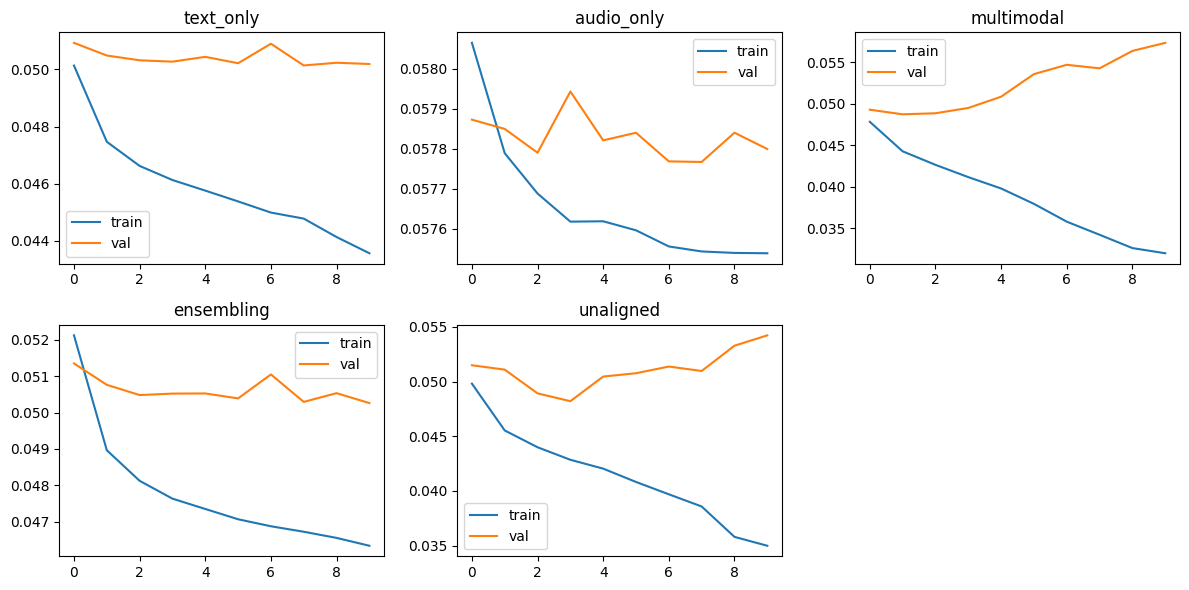

In [46]:
fig, axes = plt.subplots(5, 3, figsize=(12, 16))

for i, model_name in enumerate(history_train_losses.keys()):
    tr_losses_model = np.mean(history_train_losses[model_name], axis=0)
    vl_losses_model = np.mean(history_val_losses[model_name], axis=0)
    tr_acc = np.mean(history_train_accuracy[model_name], axis=0)
    vl_acc = np.mean(history_val_accuracy[model_name], axis=0)
    tr_f1 = np.mean([[e.item() for e in ht_l] for ht_l in history_train_f1[model_name]], axis=0)
    vl_f1 = np.mean([[e.item() for e in ht_l] for ht_l in history_val_f1[model_name]], axis=0)

    axes[i, 0].plot(tr_losses_model, label='train')
    axes[i, 0].plot(vl_losses_model, label='val')
    axes[i, 0].set_title(f'{model_name} - Loss')
    axes[i, 0].legend()

    axes[i, 1].plot(tr_acc, label='train')
    axes[i, 1].plot(vl_acc, label='val')
    axes[i, 1].set_title(f'{model_name} - Accuracy')
    axes[i, 1].legend()

    axes[i, 2].plot(tr_f1, label='train')
    axes[i, 2].plot(vl_f1, label='val')
    axes[i, 2].set_title(f'{model_name} - F1')
    axes[i, 2].legend()

plt.tight_layout()
plt.show()

Best results store for each model the results obtained in the seed which produced the highest F1 score

In [24]:
# taking the best results for each model based on the highest F1-score obtained in a seed
best_results = {
    model_name: max(test_results[model_name], key=lambda x: x['f1']) for model_name in test_results.keys()
}

## Mean and Standard Deviation for Accuracy, F1, AUC

In [25]:
# mean and standard deviation for the accuracy, F1 and AUC
aggregated_results = {}
for model_name, results in test_results.items():
    aggregated_results[model_name] = {
        'acc mean': torch.tensor([x['acc'] for x in results]).mean().item(),
        'acc std': torch.tensor([x['acc'] for x in results]).std().item(),
        'f1 mean': torch.tensor([x['f1'] for x in results]).mean().item(),
        'f1 std': torch.tensor([x['f1'] for x in results]).std().item(),
        'AUC mean': torch.tensor([roc_auc_score(x['targ'].cpu(), x['pred'].cpu()) for x in results]).mean().item(),
        'AUC std': torch.tensor([roc_auc_score(x['targ'].cpu(), x['pred'].cpu()) for x in results]).std().item(),
    }

# create multiindex dataframe with first level accuracy, f1 and second level mean and std
aggregated_results_df = pd.DataFrame(aggregated_results).T
aggregated_results_df.columns = pd.MultiIndex.from_product([['Accuracy', 'F1', 'AUC'], ['mean', 'std']])
aggregated_results_df.sort_values(by=('F1', 'mean'), ascending=False)

Accuracy          F1         AUC      
               mean   std  mean   std  mean   std
unaligned     0.700 0.003 0.699 0.002 0.699 0.002
multimodal    0.699 0.005 0.698 0.006 0.698 0.005
ensembling    0.683 0.002 0.682 0.001 0.682 0.001
text_only     0.681 0.002 0.680 0.002 0.680 0.002
audio_only    0.549 0.002 0.523 0.016 0.543 0.003

## ROC curves and AUC for the model in best_results

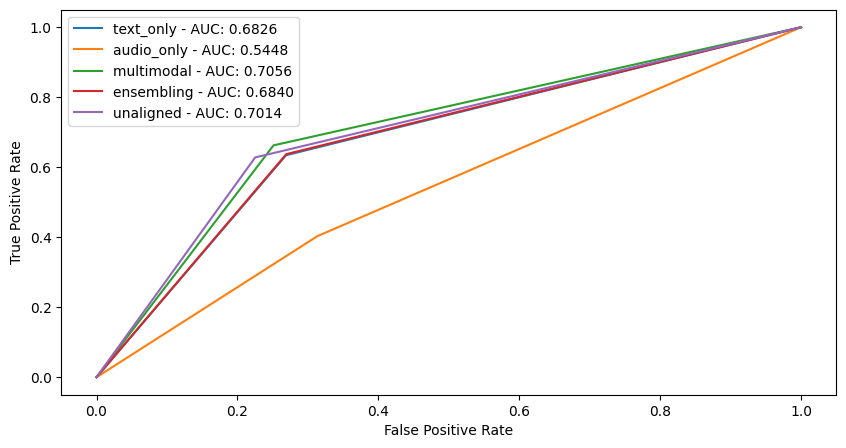

In [31]:
# plot ROC curves and compute AUC
plt.figure(figsize=(10, 5))
for model_name in test_results.keys():
    best_result = best_results[model_name]
    # compute the ROC curve
    fpr, tpr, _ = roc_curve(best_result['targ'].cpu(), best_result['pred'].cpu())
    # compute the AUC
    auc = roc_auc_score(best_result['targ'].cpu(), best_result['pred'].cpu())
    # plot the ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} - AUC: {auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Precision-Recall curves for models in best_models

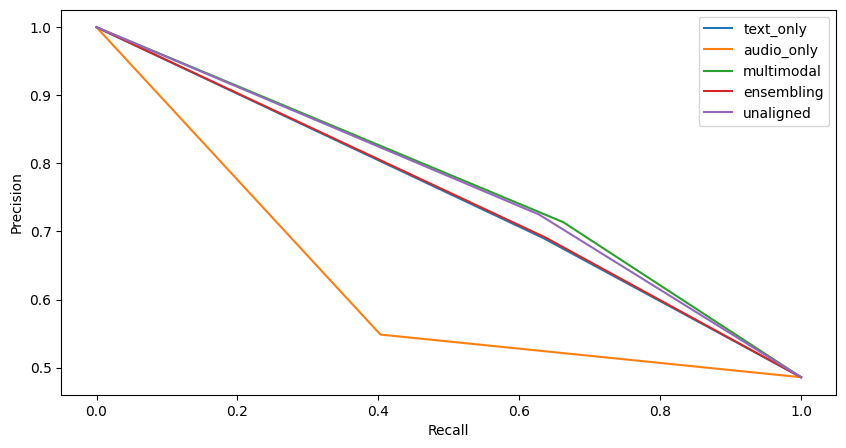

In [32]:
# plot precision-recall curves
plt.figure(figsize=(10, 5))
for model_name in test_results.keys():
    best_result = best_results[model_name]
    # compute the precision-recall curve
    precision, recall, _ = precision_recall_curve(best_result['targ'].cpu(), best_result['pred'].cpu())
    # plot the precision-recall curve
    plt.plot(recall, precision, label=f'{model_name}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Confusion Matrix for models in best_models

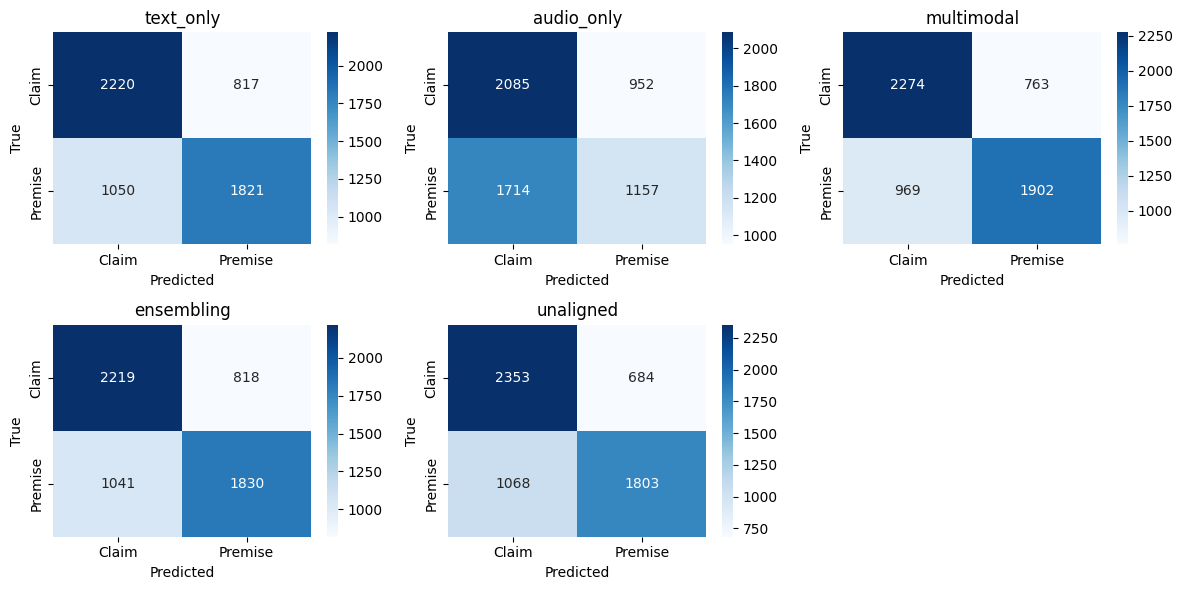

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, model_name in enumerate(test_results.keys()):
    best_result = best_results[model_name]
    
    cm = confusion_matrix([ID_2_LABEL[label.item()] for label in best_result['targ'].cpu()],
                      [ID_2_LABEL[label.item()] for label in best_result['pred'].cpu()])
                      
    sns.heatmap(cm, annot=True, ax=axes[i//3][i%3], fmt='d', cmap='Blues', xticklabels=['Claim', 'Premise'], yticklabels=['Claim', 'Premise'])
    axes[i//3][i%3].set_title(model_name)
    axes[i//3][i%3].set_xlabel('Predicted')
    axes[i//3][i%3].set_ylabel('True')
axes[1][2].axis('off')
plt.tight_layout()
plt.show()

# Breakdown analysis on the Best performing model

Best performing model: unaligned
Accuracy: 0.7035
F1: 0.7009
AUC: 0.7014

              precision    recall  f1-score   support

       Claim       0.69      0.77      0.73      3037
     Premise       0.72      0.63      0.67      2871

    accuracy                           0.70      5908
   macro avg       0.71      0.70      0.70      5908
weighted avg       0.71      0.70      0.70      5908



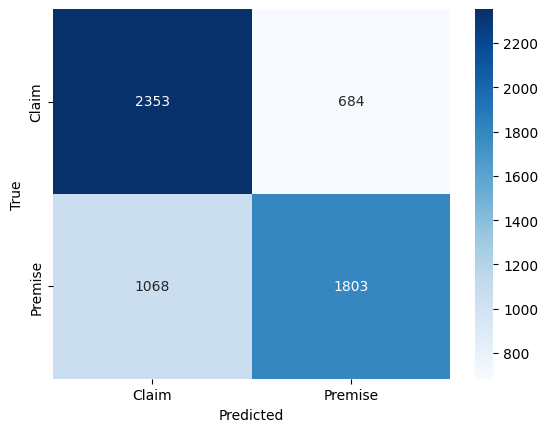

In [35]:
best_performing_model_name = max(aggregated_results_df['F1']['mean'].items(), key=lambda x: x[1])[0]

best_performing_model = max(test_results[best_performing_model_name], key=lambda x: x['f1'])

print(f'Best performing model: {best_performing_model_name}')
print(f'Accuracy: {best_performing_model["acc"]:.4f}')
print(f'F1: {best_performing_model["f1"]:.4f}')
print(f'AUC: {roc_auc_score(best_performing_model["targ"].cpu(), best_performing_model["pred"].cpu()):.4f}')
print()

print(classification_report([ID_2_LABEL[label.item()] for label in best_performing_model['targ']],
                            [ID_2_LABEL[label.item()] for label in best_performing_model['pred']])) 

cm = confusion_matrix([ID_2_LABEL[label.item()] for label in best_performing_model['targ']],
                        [ID_2_LABEL[label.item()] for label in best_performing_model['pred']])          

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Claim', 'Premise'], yticklabels=['Claim', 'Premise'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()